/home/matthew/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)



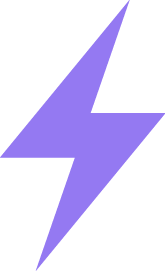

Running local mode, some functionality limited.



In [1]:
import pandas as pd
import numpy as np
from geographiclib.geodesic import Geodesic
df=pd.read_csv('networkx/usacanmex.csv').drop_duplicates('power')
df['trains'] = 0
df['power per train'] = df['power'] / (df['trains'] + 1)
####Geopy instructions are located at https://pypi.python.org/pypi/geopy ####
####DBSCAN instructions are located at 
import numpy as np
import pandas as pd
import geopy
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from pylab import *
from numpy import random
import pdb
from geopy.distance import lonlat, distance, geodesic
import os
import tarfile
pd.options.display.max_columns = 999

##### First Install Lightning using the "pip install lightning-python" Command on the C:\> Command line #######
from lightning import Lightning
lgn = Lightning(ipython=True, local=True)

def dbscanner(x, y, a, b):
    from sklearn.cluster import DBSCAN
    dbscan = DBSCAN(eps = a, min_samples = b)
    dbscan.fit(X)
    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
    import numpy as np
    core_samples = np.zeros_like(labels, dtype = bool)  
    core_samples[dbscan.core_sample_indices_] = True 
    print(core_samples)
    unique_labels = np.unique(labels)
    colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    for (label, color) in zip(unique_labels, colors):
        class_member_mask = (labels == label)
        n = X.loc[class_member_mask & core_samples, :]
        plt.plot(n.iloc[:,0],n.iloc[:,1], 'o', markerfacecolor = color, markersize = 10)

        n = X.loc[class_member_mask & ~core_samples, :]
        plt.plot(n.iloc[:,0],n.iloc[:,1], 'o', markerfacecolor = color, markersize = 5)

    plt.show()

pop = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2.csv') #from https://github.com/dphuang2/streamsets_scripts/blob/master/IM-testing/origin/API_SP.POP.TOTL_DS2_en_csv_v2.csv
latlong = pd.read_csv('simplemaps-worldcities-basic.csv') #from https://simplemaps.com/data/world-cities
pop = pop[['Country Code','2016']]
cities = pd.merge(pop, latlong, left_on='Country Code', right_on='iso3')
cities['trains'] = 0
cities['population per train'] = cities['pop'] / (cities['trains'] + 1)

In [10]:
class CreateSystem:
    def __init__(self,
                df,
                routes=1,
                debug=None):
        pop = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2.csv') #from https://github.com/dphuang2/streamsets_scripts/blob/master/IM-testing/origin/API_SP.POP.TOTL_DS2_en_csv_v2.csv
        latlong = pd.read_csv('simplemaps-worldcities-basic.csv') #from https://simplemaps.com/data/world-cities
        self.cities = pd.merge(pop, latlong, left_on='Country Code', right_on='iso3')
        self.df = df
        self.routes=routes
        self.debug=debug
    def mostpowerfulcity(self, city, direction,province=None):
        df=self.df
        if province is not None:
            cities=self.cities[self.cities['province']==province]
        else:
            cities=self.cities
        direction=direction.upper()
        latlng=cities[cities['city']==city][['lat','lng']].values[0]
        lat=latlng[0]
        lng=latlng[1]
        if province is None:
            df=pd.concat([df[df['city']==city], df[df['city_x']==city]])
        else:
            df=pd.concat([df[(df['city']==city)&(df['province']==province)], 
                              df[(df['city_x']==city)&(df['province_x']==province)]])
        if direction in ['N','S']:
            if direction=='N':
                combos=pd.concat([df[(df['city']==city)&(df['lat_x']>lat)], 
                                  df[(df['city_x']==city)&(df['lat']>lat)]])
            if direction=='S':
                combos=pd.concat([df[(df['city']==city)&(df['lat_x']<lat)], 
                                  df[(df['city_x']==city)&(df['lat']<lat)]])
            try:
                combos['geodesic']=[Geodesic.WGS84.Inverse(combos['lat'][x],
                                                           combos['lng'][x],
                                                           combos['lat_x'][x],
                                                           combos['lng_x'][x])['azi1'] for x in combos.index]
                combos['geodesic'] = [abs(x) for x in combos['geodesic']]
                combos=pd.concat([combos[combos['geodesic']<45],combos[combos['geodesic']>135]])
            except:
                return combos.sort_values('power',ascending=False)
        if direction in ['E','W']:
            if direction=='E':
                combos=pd.concat([df[(df['city']==city)&(df['lng_x']>lng)], 
                                  df[(df['city_x']==city)&(df['lng']>lng)]])
            if direction=='W':
                combos=pd.concat([df[(df['city']==city)&(df['lng_x']<lng)], 
                                  df[(df['city_x']==city)&(df['lng']<lng)]])
            combos['geodesic']=[Geodesic.WGS84.Inverse(combos['lat'][x],
                                                       combos['lng'][x],
                                                       combos['lat_x'][x],
                                                       combos['lng_x'][x])['azi1'] for x in combos.index]
            combos['geodesic'] = [abs(x) for x in combos['geodesic']]
            combos = combos[combos['geodesic'].between(45,135)]
        return combos.sort_values('power',ascending=False)
    def makeroute(self,city,direction,province=None,stops=5,max_distance=None):
        cities=[]
        print(city)
        startingcity=city
        startingprovince=province
        for n in range(0,stops):
            try:
                next_stop = self.mostpowerfulcity(startingcity,direction,province=startingprovince)
                if max_distance is not None:
                    next_stop=next_stop[next_stop['distance']<max_distance].head(1)
                else:
                    next_stop=next_stop.head(1)
                cities.append(next_stop.values)
                self.df.loc[next_stop.index[0], 'trains'] += 1
                if list(next_stop['city'])[0] == startingcity and list(next_stop['province'])[0] == startingprovince:
                    startingprovince=next_stop['province_x'].values[0]
                    startingcity = next_stop['city_x'].values[0]
                else:
                    startingcity=next_stop['city'].values[0]
                    startingprovince=next_stop['province'].values[0]
                if self.debug:
                    print(startingcity,startingprovince)
            except:
                pass
    def makesystem(self,stops=20,max_distance=None):
        for direction in ['n','s','w','e']:
            for train in range(0,round(self.routes/4)+1):
                mostpowerful = self.df.sort_values('power per train',ascending=False).head(1).to_dict()
                pop=list(mostpowerful['pop'].values())[0]
                pop_x=list(mostpowerful['pop_x'].values())[0]
                if pop > pop_x:
                    self.makeroute(list(mostpowerful['city'].values())[0], 
                                   direction, 
                                   province=list(mostpowerful['province'].values())[0],
                                   stops=stops,
                                   max_distance=max_distance)
                
            
cer=CreateSystem(df=df,routes=1000)

In [ ]:
cer.makesystem()

Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City
Mexico City


In [4]:
cer.df[['city','lng','province','city_x','province_x','lng_x','power','distance','trains','power per train']].sort_values('trains',ascending=False).head()

city         lng          province         city_x  \
72207       Vancouver -123.121644  British Columbia       Lillooet   
206        Cuernavaca  -99.240000           Morelos    Mexico City   
725455    Thunder Bay  -89.274975           Ontario      Marquette   
164584       Acapulco  -99.915979          Guerrero         Iguala   
900757  Fort St. John -120.833281  British Columbia  Prince George   

              province_x       lng_x          power    distance  trains  \
72207   British Columbia -121.933266    8185.543725  178.523022       1   
206     Distrito Federal  -99.130988  263627.409271   58.837025       1   
725455          Michigan  -87.406588     480.980414  253.783723       1   
164584          Guerrero  -99.539981    4595.233467  172.896874       1   
900757  British Columbia -122.766651     285.908945  287.579320       1   

        power per train  
72207       8185.543725  
206       263627.409271  
725455       480.980414  
164584      4595.233467  
900757       285.908945

In [ ]:
cer.df[['city','pop','lng','province','city_x','pop_x','province_x','lng_x','power','distance','trains','power per train']].sort_values('trains',ascending=False).head(1).to_dict()